# Exploratory Data Analysis

This notebook provides an exploratory data analysis (EDA) on the dataset.  This will include a data quality analysis, a class distribution analysis, and an analysis of the word counts.  The data quality analysis will include checking for missing values, duplicates, and inconsistencies.  The word counts analysis will provide a summary of the word frequencies for each text.

## Initial Data Review

Here we will import the data and perform some initial data review.  The goal is to look at a sample of the dataset, do initial data quality checks, and identify the number of classes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import sys
sys.path.append('../')

from src.eda.text_stats import add_length_column, describe_lengths, detect_author_name_leakage
from src.eda.plots import plot_boxplot, plot_cluster_label_distribution, plot_embeddings_with_labels, plot_embeddings_3d_with_labels, plot_3d_umap_plotly
from src.eda.richness import compute_lexical_metrics, group_stats
from src.features.reduction import dimension_reduction
from src.features.embeddings import vectorize_text_array
from src.utils.helpers import md_print

import matplotlib
%matplotlib inline

In [8]:
# Import the training dataset and load it into a pandas DataFrame.  
# Look at the first 5 rows of the dataset to get a sense of what the dataset looks like.  

df = pd.read_csv('../data/raw/initial_data.csv')
df.head(5)

,is_bs,text
0,1,<MASK_36777> just couldn t wish all <MASK_2208...
1,1,<MASK_5645> Chairman <MASK_51378> is going to ...
2,1,"On Friday, it was revealed that former <<MASK_..."
3,1,"On Christmas day, <MASK_18182> announced that ..."
4,1,<MASK_65357> used his annual <MASK_25972> mess...


In [9]:
# Check for missing values in the dataset. If there are any, we need to handle them appropriately.

md_print("### Number of rows:")
md_print(f"{len(df)}")
md_print("### Number of null columns:")
display(df.isnull().sum())


### Number of rows:

44727

### Number of null columns:

is_bs    0
text     0
dtype: int64

In [10]:
# Full duplication
dupes = df.duplicated(subset=["text"])
md_print(f"### Exact duplicate texts: ")
md_print(f"{dupes.sum()}")

### Exact duplicate texts: 

6250

## Class Distribution Analysis

First we need to see if our data is balanced or not. We can do this by checking the distribution of classes.  Unbalanced classes can lead to biased models. 

Let's validate that our training data is balanced by checking the class distribution using a bar chart.

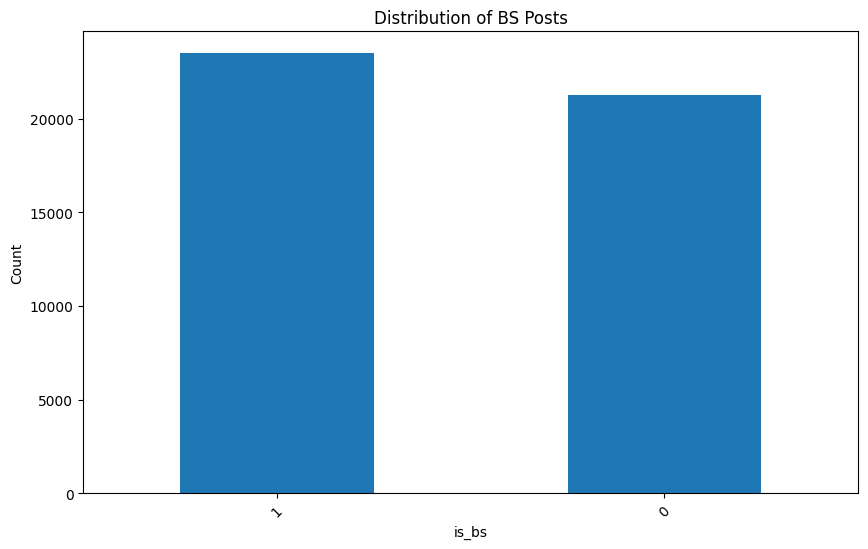

In [11]:
# Distribution of bs
plt.figure(figsize=(10, 6))
df['is_bs'].value_counts().plot(kind='bar')
plt.title('Distribution of BS Posts')
plt.xlabel('is_bs')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Vectorized Data Analysis

Here we will analyze the vectorized text data.  The idea is to embed the text into a numerical vector space and then use clustering algorithms to group similar texts together.  We can then use these clusters to identify patterns in the text data and see if they correspond to the author labels. 

In [12]:
model_name = "all-MiniLM-L6-v2"

embeddings = vectorize_text_array(df['text'], model_name)
md_print("### Embedding shape")
md_print(f"Each embedding with {model_name} has {embeddings.shape[1]} dimensions")

### Embedding shape

Each embedding with all-MiniLM-L6-v2 has 384 dimensions

/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


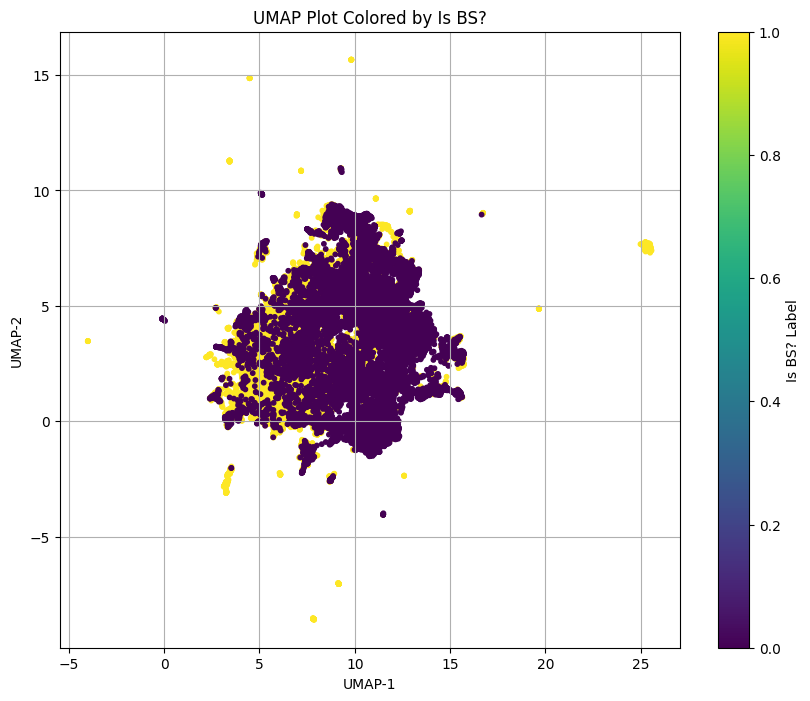

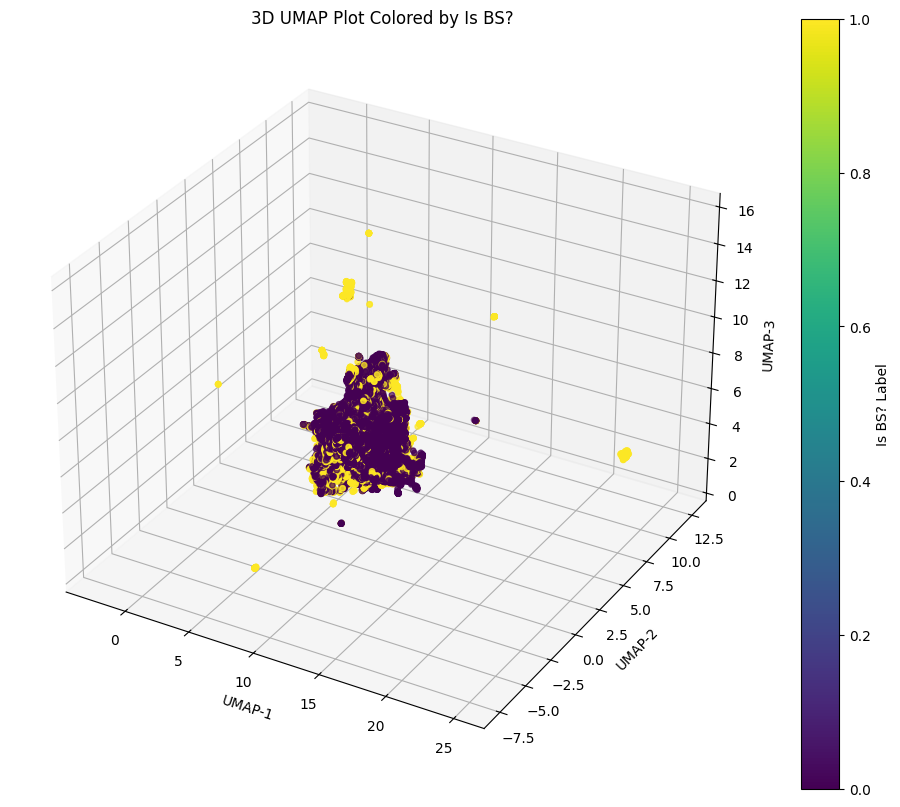

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


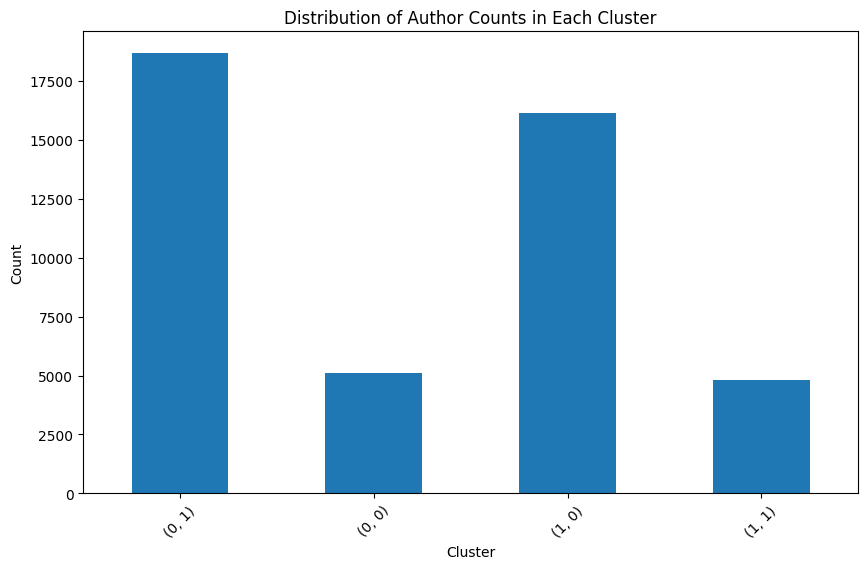

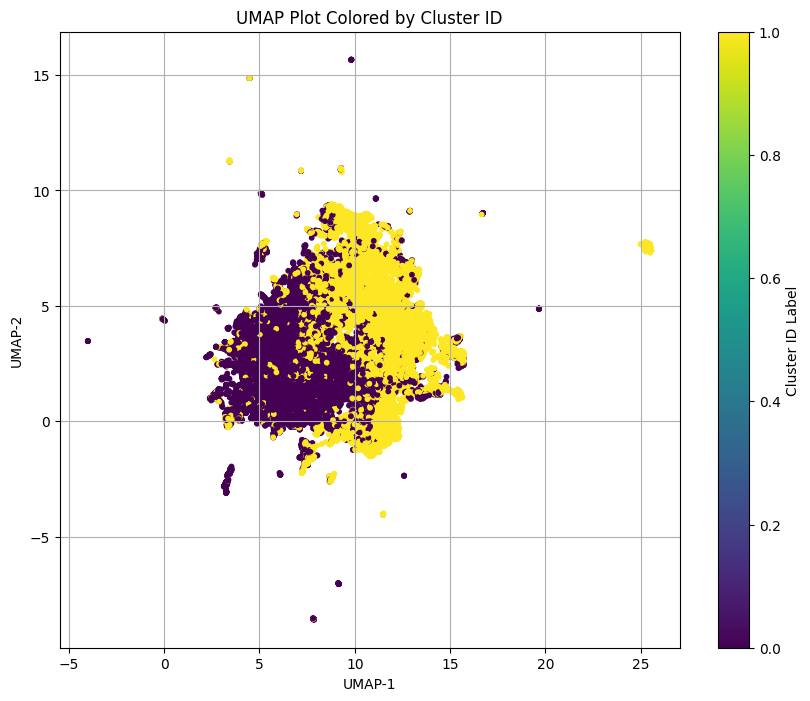

### After PCA Dimensional Reduction

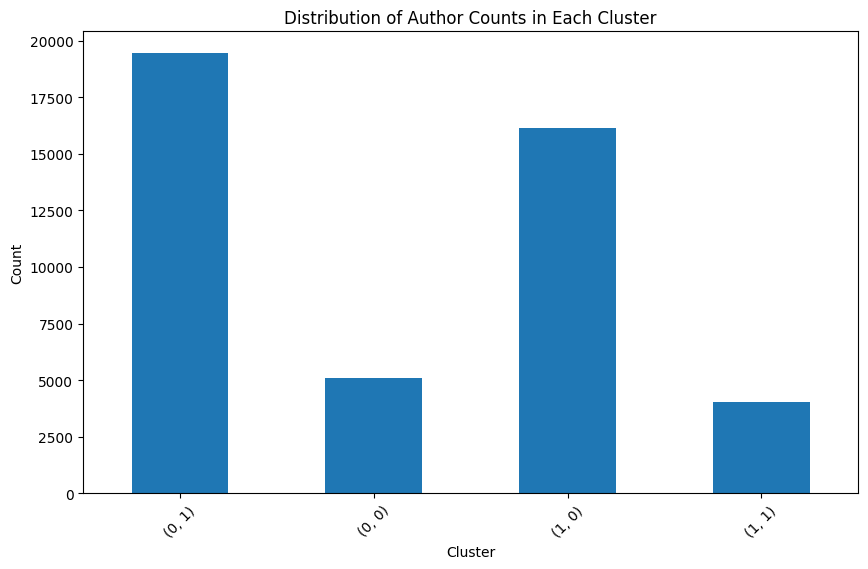

In [ ]:
# Now let's create a 2 dimensional representation of our embeddings using UMAP.  This will allow us to plot the embeddings in a 2D space and visualize them.
embeddings_2d = dimension_reduction(embeddings)
embeddings_3d = dimension_reduction(embeddings, n_components=3)

# Let's see if there is any natural clustering with our labels.  This will give us a sense of whether there is any correlation between our labels and our embeddings.
plot_embeddings_with_labels(embeddings_2d, df['is_bs'], "Is BS?")
plot_embeddings_3d_with_labels(embeddings_3d, df['is_bs'], "Is BS?")
plot_3d_umap_plotly(embeddings_3d, df['is_bs'], label_name='is_bs')

# Let's use a KMeans clustering model to cluster our text data.  
# We will only use 4 clusters, to correspond to our 4 different authors.
# Given that we already have a set number of categories, running an Elbow test is unnecessary

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(embeddings)

# Now let's see how well our clustering corresponds to our labels.
plot_cluster_label_distribution(df, kmeans)

# Let's now visualize this in 2D space.  
plot_embeddings_with_labels(embeddings_2d, kmeans.labels_, "Cluster ID")


# What happens if we reduce the dimensionality of the embeddings?
pca = PCA(n_components=150)
X_phi = pca.fit_transform(embeddings)

kmeans.fit(X_phi)

md_print("### After PCA Dimensional Reduction")
plot_cluster_label_distribution(df, kmeans)

## Text Length Analysis

Used to analyze the text length of each document in the dataset. This can be useful for understanding the distribution of text lengths across different documents and different groups.

In [8]:
# Assume your dataframe is called `df` and has columns 'text' and 'is_bs'
methods = ['chars', 'words', 'tokens']

for method in methods:
    df_aug, length_col = add_length_column(df, text_col='text', method=method)
    md_print(f"### Descriptive stats for {method}:")
    display(describe_lengths(df_aug, length_col))

    plot_boxplot(df_aug, length_col, group_col='is_bs', title_prefix=f"{method.capitalize()} Length")


### Descriptive stats for chars:

KeyError: 'author'

## Lexical Richness Check

The idea is that more lexically rich texts will be more distinctive.  Compare these two texts from J.R.R. Tolkien; the first is very lexically rich and feels like what we would expect from Tolkien.  The second is less rich and could have been written by anyone else:

> The Black Rider flung back his hood, and behold! he had a kingly crown; and yet upon no head visible was it set. The red fires shone between it and the mantled shoulders vast and dark. From a mouth unseen there came a deadly laughter.
'Old fool!' he said. 'Old fool! This is my hour. Do you not know Death when you see it? Die now and curse in vain!' And with that he lifted high his sword and flames ran down the blade.  **Return of the King**, _The Siege of Gondor_

> "Noon?" said Sam, trying to calculate.  "Noon of what day?"  **Return of the King**, _The Field of Cormallen_

The hope is that these texts are lexically rich.  We also hope that they are similarly lexically rich across the classes so the model can train on a rich and quintessential feature set.

Relevant Measurements:

1. TTR (Type-Token Ratio): number of unique words / total words
2. MTLD (Measure of Textual Lexical Diversity): stable under text length variation
3. HDD (Harmonic Mean of Lexical Diversity): harmonic mean of TTR and MTLD

For interpreting the results:
- Higher MTLD/HDD → more diverse vocabulary → potential indicator of author style.
- Lower TTR with longer texts is expected (TTR decreases as text grows).
- Consistent outliers → consider normalization or feature clipping in preprocessing.

In [ ]:
df_lex = compute_lexical_metrics(df)
# Descriptive stats per author
lex_stats = group_stats(df_lex)
measurements = ['mtld', 'ttr', 'hdd']
for m in measurements:
    md_print(f"### Statistics for _{m}_ per author:")
    display(lex_stats[m])

In [ ]:
plot_boxplot(df_lex, 'mtld', group_col='is_bs', title_prefix="Measure of Textual Lexical Diversity")
plot_boxplot(df_lex, 'ttr', group_col='is_bs', title_prefix="Type-Token Ratio")
plot_boxplot(df_lex, 'hdd', group_col='is_bs', title_prefix="Hypergeometric Distribution Diversity")


## Data Leakage Checks

Runs some tests to validate the dataset is clear of any data leakage.  These texts may need to be deleted in the training data to ensure the model can adequately generalize.

In [ ]:
author_aliases = {
    "twain": ["mark twain", "twain", "samuel clemens"],
    "doyle": ["arthur conan doyle", "conan doyle", "doyle"],
    "dickens": ["charles dickens", "dickens"],
    "defoe": ["daniel defoe", "defoe"]
}

leakage_summary = detect_author_name_leakage(df, text_col="text", label_col="author", author_aliases=author_aliases)
for k,v in leakage_summary.items():
    md_print(f"### Texts mentioning {k.capitalize()}: ")
    md_print(f"{v}")